In [42]:
import analysis
import test_features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import subplots,scatter
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_score
#from yellowbrick.features import RFECV
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost

In [66]:
data_info = pd.read_csv('data_info.csv',index_col=0).T
batch = pd.read_csv('ICC_batch.csv',header=None)
data_info['type'] = data_info['type'].map({'0':'Astrocytes','1':'Neurons'})
data_info['batch'] = batch.values
data_info['batch'] = data_info['batch'].map({0:'batch 1',1:'batch 2'})
data_tic_pp = pd.read_csv('../../sweedler_lab/Data/intensity_tic_pp2.csv',index_col=0)
data_tic_pp_imp = pd.read_csv('../../sweedler_lab/Data/intensity_tic_imp_pp.csv',index_col=0)

data_tic_pp = data_tic_pp.fillna(0)
features = np.asarray([format(float(x),'.2f') for x in data_tic_pp.columns.values]).astype(float)
data_tic_pp.columns = features

In [67]:
data_tic_pp.shape

(1544, 511)

In [44]:
norm_factors = np.sqrt(np.mean(data_tic_pp.replace(0,np.NaN)**2,axis=1)).values
norm_factors = norm_factors.reshape(data_tic_pp.shape[0],1)
data_tic_pp = np.divide(data_tic_pp,norm_factors)

# norm_factors = np.linalg.norm(data_tic_pp,ord=2,axis=1)
# data_tic_pp = data_tic_pp/norm_factors.reshape(data_tic_pp.shape[0],1)

In [68]:
types = []
batches = []
for sampleid in data_tic_pp.index.values:
    types.append(data_info[data_info['sampleID']==sampleid]['type'].values[0])
    batches.append(data_info[data_info['sampleID']==sampleid]['batch'].values[0])
#types = np.asarray(types)
types = np.asarray(types)
batches = np.asarray(batches)

In [69]:
data_tic_pp['type'] = types

In [70]:
data_tic_pp.to_pickle('ICC.pkl')

In [71]:
data_rms_pp = pd.read_pickle('ICC_rms.pkl')
data_l2_pp = pd.read_pickle('ICC_L2.pkl')
data_tic_pp = pd.read_pickle('ICC.pkl')

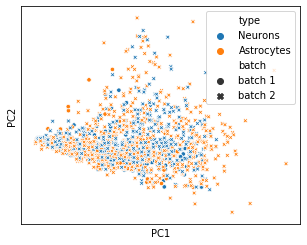

In [72]:
pca_result = analysis.PCanalysis(5,4,data_tic_pp.drop('type',1),False)

pca_df = pd.DataFrame(pca_result)
pca_df['type'] = types
pca_df['batch'] = batches

fig,axes = subplots(1,1,figsize=(5,4))
g=sns.scatterplot(x=0,y=1,hue='type',style='batch',data=pca_df,ax=axes,s=20)
g.legend(loc='upper right')
g.get_xaxis().set_ticks([])
g.get_yaxis().set_ticks([])

plt.xlabel('PC1')
plt.ylabel('PC2')
fig.savefig('plot/pca_ICC.svg')

(array([247.,  30.,  21.,  10.,  11.,  10.,  12.,  11.,   9.,   6.,   9.,
          7.,   5.,  11.,   8.,   7.,   8.,   5.,   6.,   6.,   6.,   8.,
          8.,  12.,  12.,   7.,   3.,   5.,   7.,   4.]),
 array([2.45388148e-27, 3.28245233e-02, 6.56490466e-02, 9.84735699e-02,
        1.31298093e-01, 1.64122617e-01, 1.96947140e-01, 2.29771663e-01,
        2.62596187e-01, 2.95420710e-01, 3.28245233e-01, 3.61069756e-01,
        3.93894280e-01, 4.26718803e-01, 4.59543326e-01, 4.92367850e-01,
        5.25192373e-01, 5.58016896e-01, 5.90841420e-01, 6.23665943e-01,
        6.56490466e-01, 6.89314990e-01, 7.22139513e-01, 7.54964036e-01,
        7.87788560e-01, 8.20613083e-01, 8.53437606e-01, 8.86262129e-01,
        9.19086653e-01, 9.51911176e-01, 9.84735699e-01]),
 <a list of 30 Patch objects>)

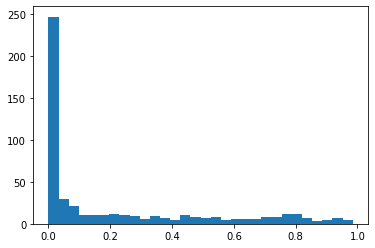

In [134]:
O,F,P=analysis.rank_sum_test(data_rms_pp.drop('type',1)[types=='Neurons'].values,
                       data_rms_pp.drop('type',1)[types=='Astrocytes'].values,features,1000)
plt.hist(P,bins=30)

In [74]:
rf_model = RandomForestClassifier(n_estimators=500)
X_train_tic, X_test_tic, y_train, y_test = train_test_split(data_tic_pp.drop('type',1).values, types, test_size=0.2,random_state=19)
X_train_rms, X_test_rms, y_train, y_test = train_test_split(data_rms_pp.drop('type',1).values, types, test_size=0.2,random_state=19)
X_train_l2, X_test_l2, y_train, y_test = train_test_split(data_l2_pp.drop('type',1).values, types, test_size=0.2,random_state=19)

X_train_batch, X_test_batch, y_train_batch, y_test_batch = train_test_split(data_tic_pp.values, batches, test_size=0.2,random_state=19)

In [76]:
xgb_tic = joblib.load('xgb_best.sav')
xgb_rms = joblib.load('xgb_best.sav')
xgb_l2 = joblib.load('xgb_best.sav')

xgb_tic.fit(X_train_tic,y_train)
xgb_rms.fit(X_train_rms,y_train)
xgb_l2.fit(X_train_l2,y_train)

y_pred_xgb_tic = xgb_tic.predict(X_test_tic)
y_pred_xgb_rms = xgb_rms.predict(X_test_rms)
y_pred_xgb_l2 = xgb_l2.predict(X_test_l2)

y_pred_xgb_prob_tic = xgb_tic.predict_proba(X_test_tic)
y_pred_xgb_prob_rms = xgb_rms.predict_proba(X_test_rms)
y_pred_xgb_prob_l2 = xgb_l2.predict_proba(X_test_l2)

report_dict_xgb_best = classification_report(y_test, y_pred_xgb_best, output_dict=True)

In [52]:
report_dict_xgb_best

{'Astrocytes': {'precision': 0.7105263157894737,
  'recall': 0.8598726114649682,
  'f1-score': 0.7780979827089337,
  'support': 157},
 'Neurons': {'precision': 0.8151260504201681,
  'recall': 0.6381578947368421,
  'f1-score': 0.7158671586715868,
  'support': 152},
 'accuracy': 0.7508090614886731,
 'macro avg': {'precision': 0.7628261831048209,
  'recall': 0.7490152531009051,
  'f1-score': 0.7469825706902602,
  'support': 309},
 'weighted avg': {'precision': 0.7619799069346697,
  'recall': 0.7508090614886731,
  'f1-score': 0.7474860563216305,
  'support': 309}}

In [31]:
def plot_featureImp_glob(model,features,feature_num_shown):
    
    feature_imp = model.feature_importances_
#     feature_imp_index_ranked = np.argsort(feature_imp)[::-1]
#     features_ranked = features[feature_imp_index_ranked]
    feature_imp = feature_imp/feature_imp.max()
    fig,ax = subplots(figsize=(6,4))
    ax.stem(features,feature_imp,markerfmt=' ')
    
    features_selected = []
    for i in range(feature_num_shown):
        ax.scatter(float(features_ranked[i]),feature_imp[feature_imp_index_ranked][i],color='k',s=10)
        ax.annotate(format(float(features_ranked[i]),'.4f'), xy=(float(features_ranked[i]),feature_imp[feature_imp_index_ranked][i]),fontsize=8)
        features_selected.append(float(features_ranked[i]))
    ax.set_ylabel('relative importance')
    ax.set_xlabel('m/z')
    return fig, features_selected

C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


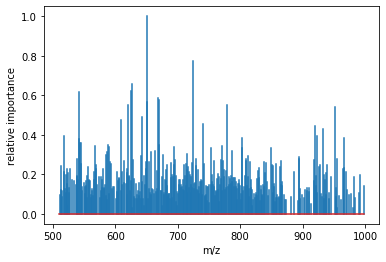

In [32]:
# _,features_selected = plot_featureImp_glob(rf_model,features,40)
# _,features_selected2 = plot_featureImp_glob(xgb_model,features,40)
_,features_selected3 = plot_featureImp_glob(xgb_best,features,0)

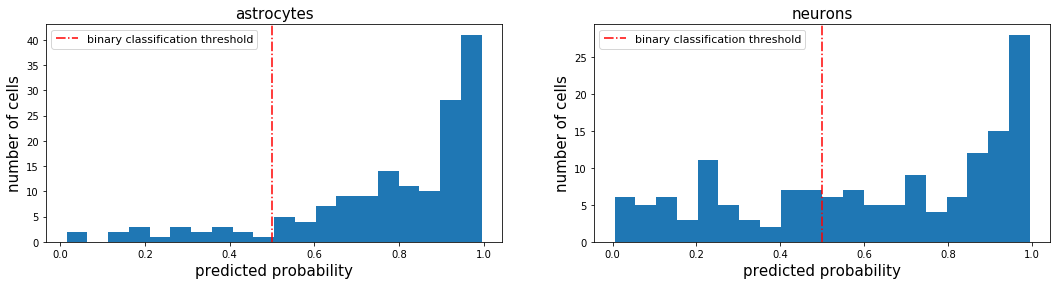

In [33]:
fig,axes = subplots(1,2,figsize=(18,4))
ax = axes.ravel()
ax[0].hist(y_pred_xgb_prob_best[y_test=='Astrocytes'][:,0],bins=20)
ax[0].set_title('astrocytes',fontsize=15)
ax[1].hist(y_pred_xgb_prob_best[y_test=='Neurons'][:,1],bins=20)
ax[1].set_title('neurons',fontsize=15)
ax[0].set_ylabel('number of cells',fontsize=15)
ax[1].set_ylabel('number of cells',fontsize=15)
ax[0].set_xlabel('predicted probability',fontsize=15)
ax[1].set_xlabel('predicted probability',fontsize=15)
ax[0].axvline(0.5,linestyle='-.',c='r',label='binary classification threshold')
ax[1].axvline(0.5,linestyle='-.',c='r',label='binary classification threshold')
ax[0].legend(fontsize=11,)
ax[1].legend(fontsize=11)

In [34]:
import shap
from adjustText import adjust_text

def feature_contrib(model,X,features,feature_num_shown,if_summary):
    
    shap_explainer = shap.TreeExplainer(model)
    shap_vals = shap_explainer.shap_values(X)
    
    fig1,axes = subplots(figsize=(12,4))
    
    g=axes.stem([float(x) for x in features],shap_vals.mean(axis=0),markerfmt=' ',linefmt='k')
    axes.get_yaxis().set_ticks([])
    shap_vals_index_ranked = np.argsort(shap_vals.mean(axis=0))[::-1]
    shap_vals_ranked = shap_vals.mean(axis=0)[shap_vals_index_ranked]
    #axes.spines['right'].set_visible(False)
    #axes.spines['top'].set_visible(False)
    texts = []
    axes.scatter(features[shap_vals_index_ranked[:feature_num_shown]],shap_vals_ranked[:feature_num_shown],color='b',s=35,marker='v',label='Neurons')
    axes.scatter(features[shap_vals_index_ranked[-feature_num_shown:]],shap_vals_ranked[-feature_num_shown:],color='orange',s=35,marker='s',label='Astrocytes')
    #for i in range(feature_num_shown):
        #texts.append(plt.text(float(features[shap_vals_index_ranked[i]]),shap_vals_ranked[i],float(features[shap_vals_index_ranked[i]]),fontsize=12))
        #texts.append(plt.text(float(features[shap_vals_index_ranked[-i-1]]),shap_vals_ranked[-i-1],float(features[shap_vals_index_ranked[-i-1]]),fontsize=12))

#         axes.annotate(format(float(features[shap_vals_index_ranked[i]]),'.2f'), xy=(float(features[shap_vals_index_ranked[i]]),shap_vals_ranked[i]),fontsize=10)
#         axes.annotate(format(float(features[shap_vals_index_ranked[-i-1]]),'.2f'), xy=(float(features[shap_vals_index_ranked[-i-1]]),shap_vals_ranked[-i]),fontsize=10)
    axes.set_xlabel('m/z',fontsize=12)
    axes.set_ylabel('mean SHAP values',fontsize=12)
    axes.legend()
    #adjust_text(texts)
    if if_summary:
        fig2,axes = subplots(figsize=(12,4))
        shap.summary_plot(shap_vals,X,max_display=15)
    return fig1,fig2,shap_vals


C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


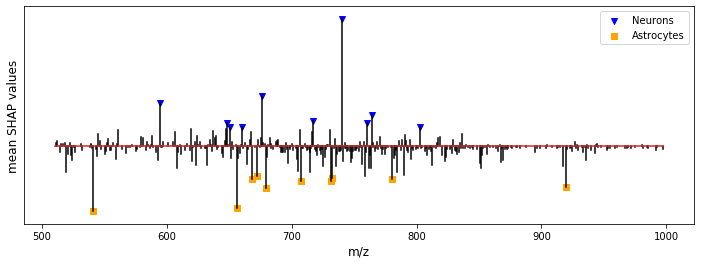

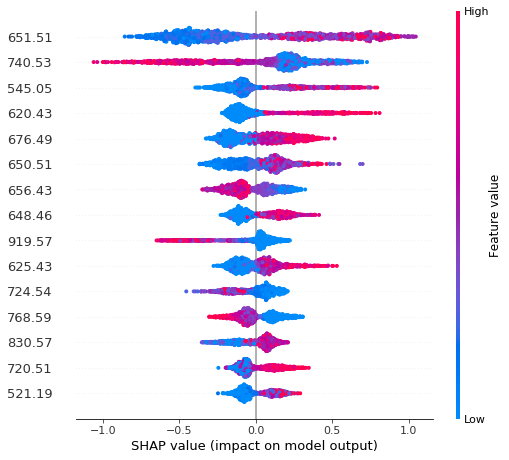

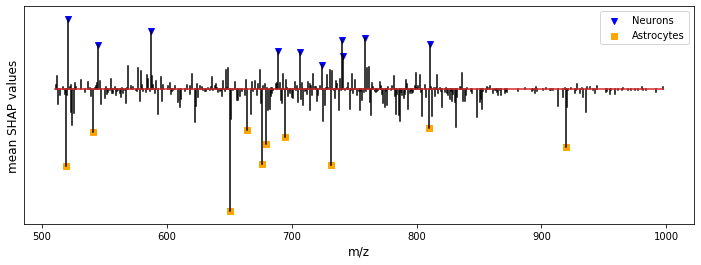

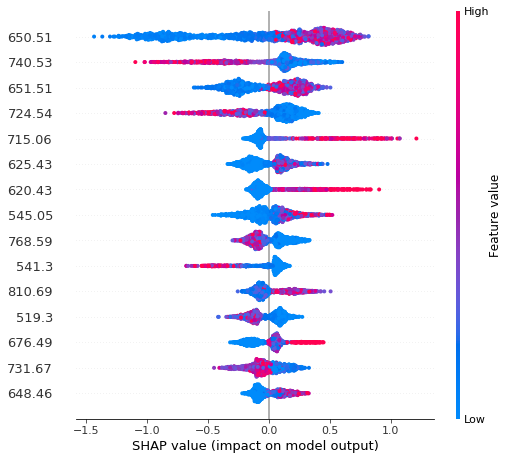

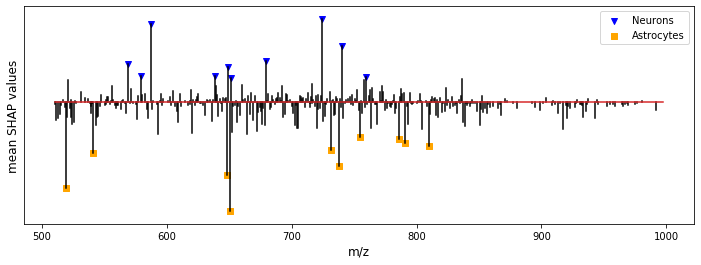

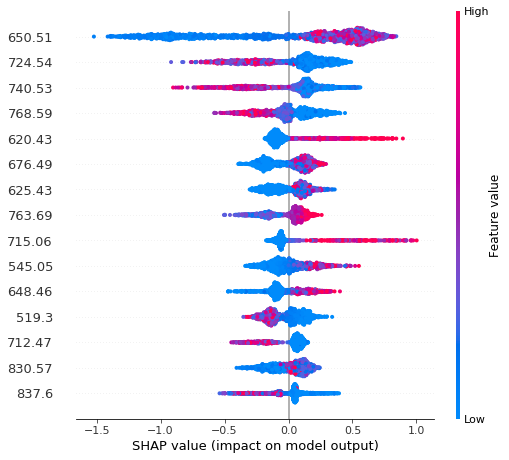

In [77]:
fig1,fig2,contrib_xgb_tic = feature_contrib(xgb_tic,data_tic_pp.drop('type',1),data_tic_pp.drop('type',1).columns,10,True)
fig1,fig2,contrib_xgb_rms = feature_contrib(xgb_rms,data_rms_pp.drop('type',1),features,10,True)
fig1,fig2,contrib_xgb_l2 = feature_contrib(xgb_l2,data_l2_pp.drop('type',1),features,10,True)

Text(0, 0.5, 'Gini importance, L2 normalization')

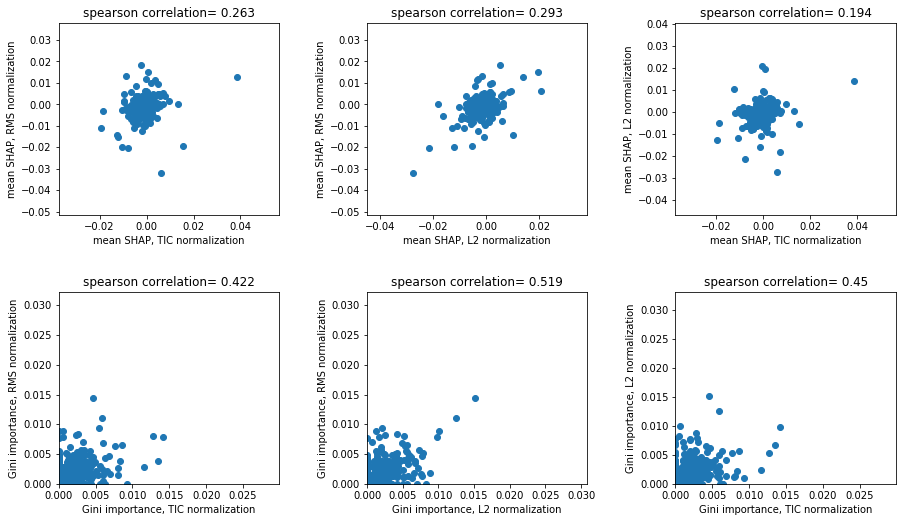

In [122]:
fig,axes = subplots(2,3,figsize=(15,8))
plt.subplots_adjust(left  = 0.125,right = 0.9,bottom = 0.1   ,top = 0.9,wspace = 0.4,hspace = 0.4)
ax = axes.ravel()
ax[0].scatter(contrib_xgb_tic.mean(0),contrib_xgb_rms.mean(0))
ax[0].set_title('spearson correlation= {}'.format(round(scipy.stats.spearmanr(contrib_xgb_tic.mean(0),contrib_xgb_rms.mean(0))[0],3)))
ax[0].set_xlabel('mean SHAP, TIC normalization')
ax[0].set_ylabel('mean SHAP, RMS normalization')
ax[1].scatter(contrib_xgb_l2.mean(0),contrib_xgb_rms.mean(0))
ax[1].set_title('spearson correlation= {}'.format(round(scipy.stats.spearmanr(contrib_xgb_l2.mean(0),contrib_xgb_rms.mean(0))[0],3)))
ax[1].set_xlabel('mean SHAP, L2 normalization')
ax[1].set_ylabel('mean SHAP, RMS normalization')
ax[2].scatter(contrib_xgb_tic.mean(0),contrib_xgb_l2.mean(0))
ax[2].set_title('spearson correlation= {}'.format(round(scipy.stats.spearmanr(contrib_xgb_tic.mean(0),contrib_xgb_l2.mean(0))[0],3)))
ax[2].set_xlabel('mean SHAP, TIC normalization')
ax[2].set_ylabel('mean SHAP, L2 normalization')
ax[3].scatter(xgb_tic.feature_importances_,xgb_rms.feature_importances_)
ax[3].set_xlim(left=0)
ax[3].set_ylim(bottom=0)
ax[3].set_title('spearson correlation= {}'.format(round(scipy.stats.spearmanr(xgb_tic.feature_importances_,xgb_rms.feature_importances_)[0],3)))
ax[3].set_xlabel('Gini importance, TIC normalization')
ax[3].set_ylabel('Gini importance, RMS normalization')
ax[4].scatter(xgb_l2.feature_importances_,xgb_rms.feature_importances_)
ax[4].set_xlim(left=0)
ax[4].set_ylim(bottom=0)
ax[4].set_title('spearson correlation= {}'.format(round(scipy.stats.spearmanr(xgb_l2.feature_importances_,xgb_rms.feature_importances_)[0],3)))
ax[4].set_xlabel('Gini importance, L2 normalization')
ax[4].set_ylabel('Gini importance, RMS normalization')
ax[5].scatter(xgb_tic.feature_importances_,xgb_l2.feature_importances_)
ax[5].set_xlim(left=0)
ax[5].set_ylim(bottom=0)
ax[5].set_title('spearson correlation= {}'.format(round(scipy.stats.spearmanr(xgb_tic.feature_importances_,xgb_l2.feature_importances_)[0],3)))
ax[5].set_xlabel('Gini importance, TIC normalization')
ax[5].set_ylabel('Gini importance, L2 normalization')


In [60]:
fig1.savefig('plot/contribution_plot_ICC_2.svg')
#fig2.savefig('plot/shap_plot_ICC.svg')

In [138]:
shap_ranked_index = np.argsort(abs(contrib_xgb_rms.mean(0)))[::-1]
gini_ranked_index = np.argsort(abs(xgb_rms.feature_importances_))[::-1]
rst_ranked_index = np.argsort(-P)[::-1]

shared_shap_gini = set(shap_ranked_index[:60]).intersection(set(gini_ranked_index[:60]))
shared_shap_rst = set(shap_ranked_index[:60]).intersection(set(rst_ranked_index[:60]))
shared_gini_rst = set(gini_ranked_index[:60]).intersection(set(rst_ranked_index[:60]))
shared_all = set(gini_ranked_index[:60]).intersection(set(rst_ranked_index[:60])).intersection(set(shap_ranked_index[:60]))

print(len(shared_shap_gini),len(shared_shap_rst),len(shared_gini_rst),len(shared_all))

14 17 12 6


In [139]:
common_feature = features[list(shared_all)]
common_feature = common_feature[np.argsort(common_feature)]
common_feature

array([587.36, 650.51, 651.51, 676.49, 724.54, 758.63])

In [38]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator

def shap_clustering(shap_vals,groups):
    
    shap_pca50 = PCA(n_components=12).fit_transform(shap_vals)
    #shap_embedded = TSNE(n_components=2, perplexity=25).fit_transform(shap_vals)
    
    cdict1 = {
        'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
                (1.0, 0.9607843137254902, 0.9607843137254902)),

        'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
                  (1.0, 0.15294117647058825, 0.15294117647058825)),

        'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
                 (1.0, 0.3411764705882353, 0.3411764705882353)),

        'alpha': ((0.0, 1, 1),
                  (0.5, 1, 1),
                  (1.0, 1, 1))
    }  # #1E88E5 -> #ff0052
    red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)
    
    shap_embedded_df = pd.DataFrame(shap_pca50)
    shap_embedded_df['type'] = groups

    f1,axes= subplots(1,1,figsize=(5,4))
    g = sns.scatterplot(x=0,y=1,hue='type',data=shap_embedded_df,ax=axes)
    g.legend(loc='upper right')
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.get_yaxis().set_ticks([])
    axes.get_xaxis().set_ticks([])
    axes.set_xlabel('PC1',fontsize=12)
    axes.set_ylabel('PC2',fontsize=12)
    
    f2,axes= subplots(1,1,figsize=(6,4))
    plt.scatter(shap_pca50[:,0],
           shap_pca50[:,1],
           c=shap_vals.sum(1).astype(np.float64),
           linewidth=0, alpha=0.9, cmap=red_blue_solid)
    cb = plt.colorbar(label="Log odds of being astrocytes or neurons", aspect=40, orientation="vertical")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position('bottom')
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.get_yaxis().set_ticks([])
    axes.get_xaxis().set_ticks([])
    axes.set_xlabel('PC1',fontsize=12)
    axes.set_ylabel('PC2',fontsize=12)
    plt.show()
    return f1,f2,shap_pca50

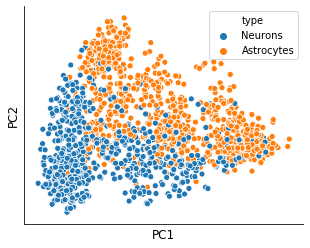

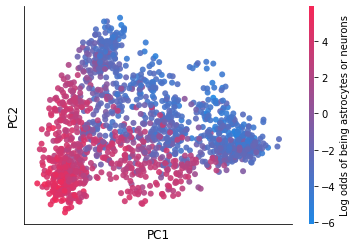

In [123]:
f1,f2,shap_pca_df = shap_clustering(contrib_xgb_rms,types)

In [128]:
f1.savefig('plot/pca_SHAP_ICC.svg')
f2.savefig('plot/pca_SHAP_prob_ICC.svg')

In [40]:
def plot_shap_features(shap_vals,X,FOI):
    
    shap_pca = PCA(n_components=12).fit_transform(shap_vals)
    cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
    }  # #1E88E5 -> #ff0052
    red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)
    row_plot = int(np.ceil(len(FOI)/3))
    f,axes = subplots(3,row_plot,figsize=(row_plot*5,10))
    ax = axes.ravel()
    index = 0
    for feature in FOI:
        fig=ax[index].scatter(shap_pca[:,0],
                   shap_pca[:,1],
                   c=X[feature].values[:10000].astype(np.float64),
                   linewidth=0, alpha=0.75, cmap=red_blue_solid)
        cb=plt.colorbar(fig, aspect=40, orientation="vertical",ax=ax[index])
        cb.set_alpha(1)
        cb.set_label(label='normalized intensity',size=12)
        cb.draw_all()
        cb.outline.set_linewidth(0)
        cb.ax.tick_params('x', length=0)
        cb.ax.xaxis.set_label_position('top')
        ax[index].set_title(format(float(feature),'.2f')+' m/z',fontsize=15)
        ax[index].axis("off")
        index += 1
    return f

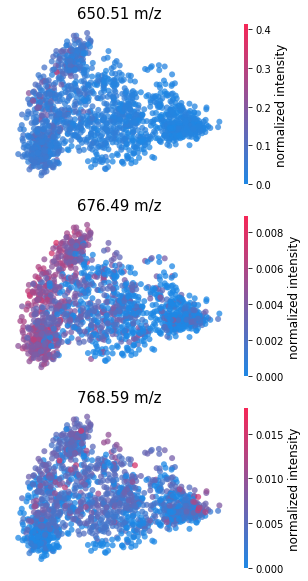

In [129]:
f=plot_shap_features(contrib_xgb_best,data_tic_pp,[650.51,676.49,768.59])
f.savefig('plot/SHAP_features_ICC.svg')

In [267]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [268]:
import warnings
warnings.filterwarnings('ignore')

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [269]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 7,10],
        'learning_rate':[0.1,0.05,0.01,0.005],
        'reg_alpha':[0,1e-5, 1e-2, 0.1, 1]
        }

In [270]:
xgb = xgboost.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 19)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc',
                                   n_jobs=8, cv=skf.split(X_train,y_train), verbose=3, random_state=19 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  19 out of  25 | elapsed:   49.1s remaining:   15.4s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:   57.9s finished



 Time taken: 0 hours 1 minutes and 12.72 seconds.


In [271]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([32.03315392, 16.91876497, 11.92312179,  9.90033011,  9.36198545]), 'std_fit_time': array([0.17809192, 0.20199103, 0.21695388, 0.63792741, 0.27904303]), 'mean_score_time': array([0.00917563, 0.00977387, 0.009375  , 0.00718083, 0.00718231]), 'std_score_time': array([0.00097731, 0.00097746, 0.00119689, 0.0009773 , 0.00039985]), 'param_subsample': masked_array(data=[0.6, 1.0, 0.8, 0.8, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_reg_alpha': masked_array(data=[1, 0, 0.01, 1, 0.01],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 5, 10, 5, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[10, 4, 4, 3, 4],
             mask=[False, False, False, False, False],
       fill_value='?'

In [274]:
xgb_best = xgboost.XGBClassifier(learning_rate=0.1, n_estimators=600, objective='binary:logistic',
                    subsample=1,reg_alpha=0,min_child_weight=5,max_depth=4,gamma=0,colsample_bytree=1)

xgb_best.fit(X_train,y_train)

y_pred_xgb_best = xgb_best.predict(X_test)
y_pred_xgb_prob_best = xgb_best.predict_proba(X_test)
report_dict_xgb_best = classification_report(y_test, y_pred_xgb_best, output_dict=True)

In [17]:
joblib.dump(xgb_best,'xgb_best_2.sav')

['xgb_best.sav']